In [1]:
import torchtext
import torch
import torch.nn as nn
from torch_struct import DependencyCRF
import torch_struct.data 
import torchtext.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:
def batch_num(nums):
    lengths = torch.tensor([len(n) for n in nums]).long()
    n = lengths.max()
    out = torch.zeros(len(nums), n).long()
    for b, n in enumerate(nums):
        out[b, :len(n)] = torch.tensor(n)
    return out, lengths
HEAD = data.RawField(preprocessing= lambda x: [int(i) for i in x],
                     postprocessing=batch_num, 
                     is_target = True)
WORD = data.Field(pad_token=None)
train = torch_struct.data.ConllXDataset("wsj.train0.conllx", (('word', WORD), ('head', HEAD)),
                     ) #filter_pred=lambda x: 5 < len(x.word) < 40
val = torch_struct.data.ConllXDataset("wsj.train0.conllx", (('word', WORD), ('head', HEAD)),
                     ) #  filter_pred=lambda x: 5 < len(x.word[0]) < 40
WORD.build_vocab(train)
train_iter = data.BucketIterator(train, batch_size=2, device='cpu', shuffle=False)
val_iter = data.BucketIterator(val, batch_size=2, device="cpu", shuffle=False)

In [3]:
V = len(WORD.vocab.itos)

class Model(nn.Module):
    def __init__(self, hidden):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.eye(V).type(torch.FloatTensor), freeze=True) #one hot 
        # F.one_hot(torch.arange(V))
        self.linear = nn.Linear(V, V)
        self.bilinear = nn.Linear(V, V)

        self.root = nn.Parameter(torch.rand(V))
        
    def forward(self, words):
        out = self.embedding(words) # (b x N ) -> (b x N x V)
        final2 = self.linear(out) # (b x N x V) (V x V) -> (b x N x V)
        final = torch.einsum("bnh,hg,bmg->bnm", out, self.bilinear.weight, final2) # (N x V) (V x V) (N x V)^T -> (N, N)
        #print('ein3', final.shape)
        root_score = torch.einsum("bnh,h->bn", out, self.root) # (N x V) x V -> N
        #print('root', root_score)

        N = final.shape[1]
        final[:, torch.arange(N), torch.arange(N)] += root_score
        #print('f2', final.shape)
        return final

model = Model(V)
opt = optim.SGD(model.parameters(), lr=1e-4)

In [4]:
def show_deps(tree):
    plt.imshow(tree.detach())

def validate(val_iter):
    incorrect_edges = 0
    total_edges = 0
    model.eval()
    for i, ex in enumerate(val_iter):
        words = ex.word.transpose(0,1)
        label, lengths = ex.head

        final = model(words) #.cuda()

        dist = DependencyCRF(final, lengths=lengths)
        argmax = dist.argmax
        gold = dist.struct.to_parts(label, lengths=lengths).type_as(argmax)
        incorrect_edges += (argmax[:, :].cpu() - gold[:, :].cpu()).abs().sum() / 2.0
        total_edges += gold.sum()

        gold1 = DependencyCRF(gold, lengths=lengths)

    print(total_edges, incorrect_edges)   
    model.train()
    return gold1

def trn(train_iter, model):
    for epoch in range(100):
        model.train()
        losses = []

        for i, ex in enumerate(train_iter):
            #print(i)
            # print(ex.word.shape) # sq x b
            # print(ex.head[0].shape) # b x sq
            # print('lens', ex.head[1])
            
            words = ex.word.transpose(0,1)
            label, lengths = ex.head
            #batch, _ = label.shape
            
            final = model(words)
            #print(model.embedding.weight)
            #print(final)
            dist = DependencyCRF(final, lengths=lengths)
            # dist.multiroot=False

            labels = dist.struct.to_parts(label, lengths=lengths).type_as(final)
            #print('labels', labels.shape)

            log_prob = dist.log_prob(labels)
            #print(log_prob.shape)

            loss = log_prob.sum()
            (-loss).backward()
            losses.append(loss.detach())
            opt.step()

        if epoch % 10 == 1:            
            print(i, -torch.tensor(losses).mean(), words.shape)
            losses = []
            show_deps(dist.argmax[0])
            plt.show()
            
        if epoch % 10 == 1:
            gold = validate(val_iter)        
            show_deps(gold.argmax[0])
            plt.show()

6 tensor(65.5116) torch.Size([2, 17])


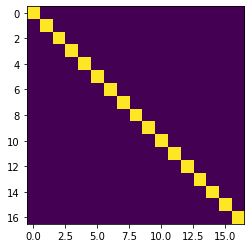

tensor(276.) tensor(264.)


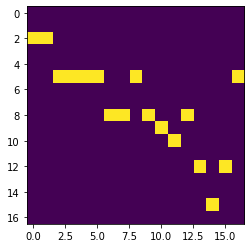

6 tensor(57.9000) torch.Size([2, 17])


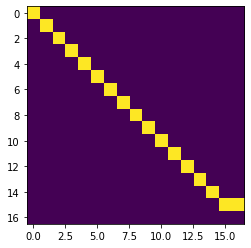

tensor(276.) tensor(230.)


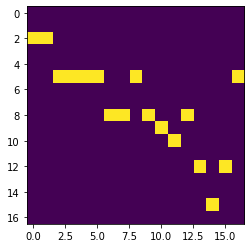

6 tensor(44.3512) torch.Size([2, 17])


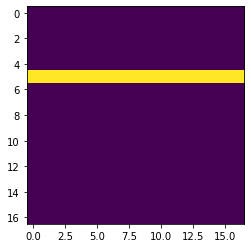

tensor(276.) tensor(198.)


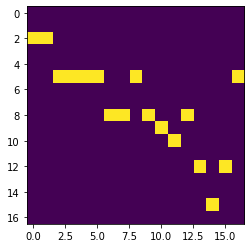

6 tensor(40.6170) torch.Size([2, 17])


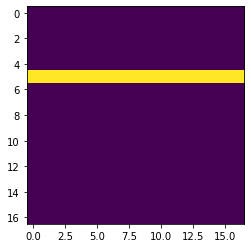

tensor(276.) tensor(177.)


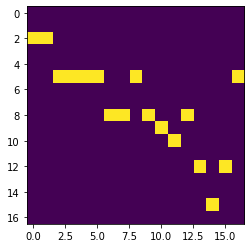

6 tensor(34.0496) torch.Size([2, 17])


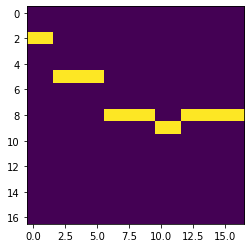

tensor(276.) tensor(139.)


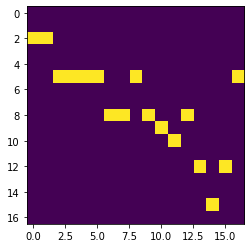

6 tensor(24.7924) torch.Size([2, 17])


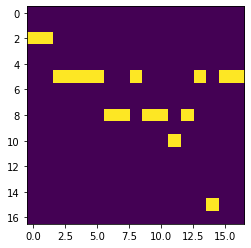

tensor(276.) tensor(75.)


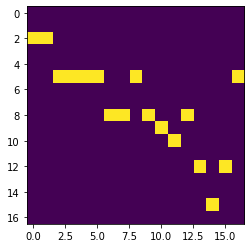

6 tensor(11.0956) torch.Size([2, 17])


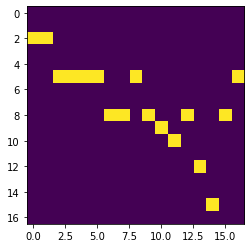

tensor(276.) tensor(9.)


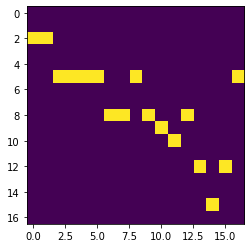

6 tensor(6.1001) torch.Size([2, 17])


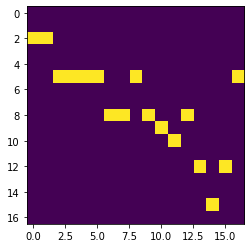

tensor(276.) tensor(6.)


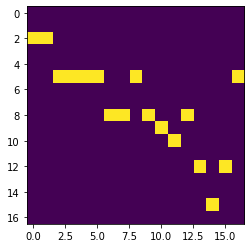

6 tensor(3.8229) torch.Size([2, 17])


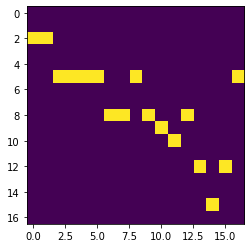

tensor(276.) tensor(7.)


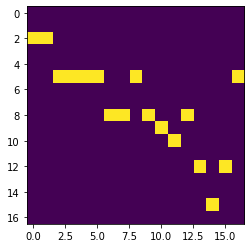

6 tensor(2.5434) torch.Size([2, 17])


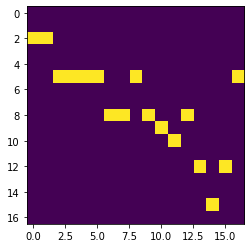

tensor(276.) tensor(5.)


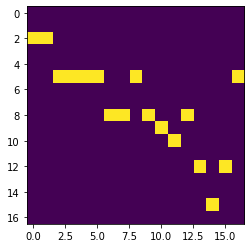

In [5]:
trn(train_iter, model)